In [43]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import time
import shap
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import xgboost as xgb
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
import sys
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
import os


pd.options.display.max_rows = 2000
pd.options.display.max_columns = 200

In [35]:
df_raw = pd.read_csv('data.csv')

In [44]:
df_raw.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,0.420000,0.49500,0.330,0.36000,0.500,1.0000,0.00,0.0,50.0000,20.0000,84.000,45.0000,76.5000,41.000,114.000,64.00,1.500,1.0,9.0,6.500,39.500,11.000,63.0000,27.500,7.5000,7.0000,12.0000,9.0000,3.000,2.000,9.000,8.500,35.0000,12.5,43.5000,17.5000,10.5000,4.5000,4.0000,3.00,4.5000,3.000,36.50,24.50,34.00,277.5000,531.5,4,0,0,1,1,1,1,0,0,0,0,0,1,0,Orthodox,165.10,170.18,135.0,1.000000,0.000000,0.500000,0.460000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00,34.000000,17.000000,13.00000,6.000000,35.000000,18.000000,16.000000,9.000000,0.000000,0.000000,3.000000,0.000000,32.00000,15.000000,11.000000,5.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,33.000000,16.000000,12.000000,6.000000,1.000000,1.000000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,54.000000,166.000000,1,0,1,0,1,1,0,0,0,0,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,0.660000,0.30500,0.300,0.50000,1.500,0.0000,0.00,0.0,65.5000,35.0000,50.000,16.5000,113.5000,68.500,68.500,29.00,2.500,1.5,0.5,0.500,46.000,20.000,36.0000,7.500,12.0000,8.0000,8.0000,3.0000,7.500,7.000,6.000,6.000,58.0000,30.0,48.0000,15.5000,0.5000,0.5000,0.5000,0.50,7

In [37]:
df_raw.info(null_counts = True, verbose = True, memory_usage = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 144 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    R_fighter                     6012 non-null   object 
 1    B_fighter                     6012 non-null   object 
 2    Referee                       5980 non-null   object 
 3    date                          6012 non-null   object 
 4    location                      6012 non-null   object 
 5    Winner                        6012 non-null   object 
 6    title_bout                    6012 non-null   bool   
 7    weight_class                  6012 non-null   object 
 8    B_avg_KD                      4585 non-null   float64
 9    B_avg_opp_KD                  4585 non-null   float64
 10   B_avg_SIG_STR_pct             4585 non-null   float64
 11   B_avg_opp_SIG_STR_pct         4585 non-null   float64
 12   B_avg_TD_pct                  4585 non-null   

In [38]:
df_raw.Winner.value_counts()

Red     3979
Blue    1923
Draw     110
Name: Winner, dtype: int64

In [99]:
df_red = df_raw.copy()
df_red['won'] = (df_red.Winner == 'Red').astype('int')
df_red.columns = [col.replace('B_','Opp_',1) if col.startswith('B_') else col for col in df_red.columns.values]
df_red.columns = [col.replace('R_','Player_',1) if col.startswith('R_') else col for col in df_red.columns.values]
df_blue = df_raw.copy()
df_blue['won'] = (df_blue.Winner == 'Blue').astype('int')
df_blue.columns = [col.replace('R_','Opp_',1) if col.startswith('R_') else col for col in df_blue.columns.values]
df_blue.columns = [col.replace('B_','Player_',1) if col.startswith('B_') else col for col in df_blue.columns.values]

In [100]:
df = pd.concat([df_red,df_blue], ignore_index = True)

In [137]:
df.sort_values(by = ['Player_fighter','date'], ascending = [True,True], inplace = True)
df.reset_index(inplace = True, drop = True)
df['date'] = pd.to_datetime(df.date)
df['prev_fight_date'] = df.groupby('Player_fighter').date.shift(1)
df['time_since_last_fight'] = (df.date - df.prev_fight_date).dt.days

In [155]:
df['career_wc_factorized']= df.groupby('Player_fighter').weight_class.transform(lambda x: pd.factorize(x)[0]+1)
df['career_weight_classes'] = df.groupby('Player_fighter').career_wc_factorized.transform('cummax')
df['total_title_bouts_until_fight'] = df.groupby('Player_fighter').title_bout.transform('cumsum')

In [157]:
df.info(verbose = True,null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12024 entries, 0 to 12023
Data columns (total 150 columns):
 #    Column                             Non-Null Count  Dtype         
---   ------                             --------------  -----         
 0    Player_fighter                     12024 non-null  object        
 1    Opp_fighter                        12024 non-null  object        
 2    Referee                            11960 non-null  object        
 3    date                               12024 non-null  datetime64[ns]
 4    location                           12024 non-null  object        
 5    Winner                             12024 non-null  object        
 6    title_bout                         12024 non-null  bool          
 7    weight_class                       12024 non-null  object        
 8    Opp_avg_KD                         9885 non-null   float64       
 9    Opp_avg_opp_KD                     9885 non-null   float64       
 10   Opp_avg_SIG_STR_pct 

# EDA

In [65]:
def ttest(df,target, feature):
    pos_class = df[df[target]==1][feature]
    neg_class = df[df[target]==0][feature]
    tstat, pval = stats.ttest_ind(pos_class, neg_class, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, pval))
    
def describe_cont_feature(df,target,feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby(target)[feature].describe())
    print(ttest(df, target, feature))

def quad_plot(df, feature, target, logistic = True):
    f, axes = plt.subplots(2, 2,figsize=(15,15))
    # top left swarm with boxplot
    sns.boxplot(x=df[target], y=df[feature], palette = "viridis", ax = axes[0][0])
    sns.violinplot(x=df[target], y=df[feature], color="turquoise", ax = axes[0][0])
    plt.setp(axes[0][0].collections, alpha=.3)
    # top right cumulative density plot
    sns.kdeplot(data = df, x = feature, hue = target, palette= "viridis_r", multiple = "fill", ax = axes[0][1])
    axes[0][1].legend([target,"not {}".format(target)])
    if (df[feature].min() > 0):
        axes[0][1].set_xlim(left = 0)
    # bottom left regression plot either logistic or regular
    if logistic == False:
        sns.regplot(data = df, x= feature,y= target,logistic = False,color = 'teal', ax = axes[1][0])
    else:
        sns.regplot(data = df, x= feature,y= target,logistic = True,color = 'teal', ax = axes[1][0])
    # bottom right is are comparing the distributions of the features between positive and negative class
    sns.distplot(df.loc[df[target] != 1,feature], color = 'teal', ax = axes[1][1])
    sns.distplot(df.loc[df[target] == 1,feature], color = 'purple', ax = axes[1][1])
    if (df[feature].min() > 0):
        axes[1][1].set_xlim(left = 0)
    plt.show()
    
def univariate_breakdown(df, feature, target, logistic = True):
    
    describe_cont_feature(df,target,feature)
    #quad_plot(df, feature, target, logistic = logistic)

def cols_analysis(df, target, ignore_cols = []):
    continuous_cols = [col for col in df.columns if col not in ignore_cols]
    for col in continuous_cols:
        print("Pearson correlation of {} to target {}: {}"
              .format(col, target, df[col].corr(df[target])))
        univariate_breakdown(df, col ,target)
        

In [158]:
cont_cols = ['Opp_avg_KD',
       'Opp_avg_opp_KD', 'Opp_avg_SIG_STR_pct', 'Opp_avg_opp_SIG_STR_pct',
       'Opp_avg_TD_pct', 'Opp_avg_opp_TD_pct', 'Opp_avg_SUB_ATT',
       'Opp_avg_opp_SUB_ATT', 'Opp_avg_REV', 'Opp_avg_opp_REV',
       'Opp_avg_SIG_STR_att', 'Opp_avg_SIG_STR_landed',
       'Opp_avg_opp_SIG_STR_att', 'Opp_avg_opp_SIG_STR_landed',
       'Opp_avg_TOTAL_STR_att', 'Opp_avg_TOTAL_STR_landed',
       'Opp_avg_opp_TOTAL_STR_att', 'Opp_avg_opp_TOTAL_STR_landed',
       'Opp_avg_TD_att', 'Opp_avg_TD_landed', 'Opp_avg_opp_TD_att',
       'Opp_avg_opp_TD_landed', 'Opp_avg_HEAD_att', 'Opp_avg_HEAD_landed',
       'Opp_avg_opp_HEAD_att', 'Opp_avg_opp_HEAD_landed',
       'Opp_avg_BODY_att', 'Opp_avg_BODY_landed', 'Opp_avg_opp_BODY_att',
       'Opp_avg_opp_BODY_landed', 'Opp_avg_LEG_att', 'Opp_avg_LEG_landed',
       'Opp_avg_opp_LEG_att', 'Opp_avg_opp_LEG_landed',
       'Opp_avg_DISTANCE_att', 'Opp_avg_DISTANCE_landed',
       'Opp_avg_opp_DISTANCE_att', 'Opp_avg_opp_DISTANCE_landed',
       'Opp_avg_CLINCH_att', 'Opp_avg_CLINCH_landed',
       'Opp_avg_opp_CLINCH_att', 'Opp_avg_opp_CLINCH_landed',
       'Opp_avg_GROUND_att', 'Opp_avg_GROUND_landed',
       'Opp_avg_opp_GROUND_att', 'Opp_avg_opp_GROUND_landed',
       'Opp_avg_CTRL_time(seconds)', 'Opp_avg_opp_CTRL_time(seconds)',
       'Opp_total_time_fought(seconds)', 'Opp_total_rounds_fought',
       'Opp_total_title_bouts', 'Opp_current_win_streak',
       'Opp_current_lose_streak', 'Opp_longest_win_streak', 'Opp_wins',
       'Opp_losses', 'Opp_win_by_Decision_Majority',
       'Opp_win_by_Decision_Split', 'Opp_win_by_Decision_Unanimous',
       'Opp_win_by_KO/TKO', 'Opp_win_by_Submission',
       'Opp_win_by_TKO_Doctor_Stoppage', 'Opp_Height_cms',
       'Opp_Reach_cms', 'Opp_Weight_lbs', 'Player_avg_KD',
       'Player_avg_opp_KD', 'Player_avg_SIG_STR_pct',
       'Player_avg_opp_SIG_STR_pct', 'Player_avg_TD_pct',
       'Player_avg_opp_TD_pct', 'Player_avg_SUB_ATT',
       'Player_avg_opp_SUB_ATT', 'Player_avg_REV', 'Player_avg_opp_REV',
       'Player_avg_SIG_STR_att', 'Player_avg_SIG_STR_landed',
       'Player_avg_opp_SIG_STR_att', 'Player_avg_opp_SIG_STR_landed',
       'Player_avg_TOTAL_STR_att', 'Player_avg_TOTAL_STR_landed',
       'Player_avg_opp_TOTAL_STR_att', 'Player_avg_opp_TOTAL_STR_landed',
       'Player_avg_TD_att', 'Player_avg_TD_landed',
       'Player_avg_opp_TD_att', 'Player_avg_opp_TD_landed',
       'Player_avg_HEAD_att', 'Player_avg_HEAD_landed',
       'Player_avg_opp_HEAD_att', 'Player_avg_opp_HEAD_landed',
       'Player_avg_BODY_att', 'Player_avg_BODY_landed',
       'Player_avg_opp_BODY_att', 'Player_avg_opp_BODY_landed',
       'Player_avg_LEG_att', 'Player_avg_LEG_landed',
       'Player_avg_opp_LEG_att', 'Player_avg_opp_LEG_landed',
       'Player_avg_DISTANCE_att', 'Player_avg_DISTANCE_landed',
       'Player_avg_opp_DISTANCE_att', 'Player_avg_opp_DISTANCE_landed',
       'Player_avg_CLINCH_att', 'Player_avg_CLINCH_landed',
       'Player_avg_opp_CLINCH_att', 'Player_avg_opp_CLINCH_landed',
       'Player_avg_GROUND_att', 'Player_avg_GROUND_landed',
       'Player_avg_opp_GROUND_att', 'Player_avg_opp_GROUND_landed',
       'Player_avg_CTRL_time(seconds)','Player_avg_opp_CTRL_time(seconds)',
       'Player_total_time_fought(seconds)', 'Player_total_rounds_fought',
       'Player_total_title_bouts', 'Player_current_win_streak',
       'Player_current_lose_streak', 'Player_longest_win_streak',
       'Player_wins', 'Player_losses', 
       'Player_win_by_Decision_Majority', 'Player_win_by_Decision_Split',
       'Player_win_by_Decision_Unanimous', 'Player_win_by_KO/TKO',
       'Player_win_by_Submission', 'Player_win_by_TKO_Doctor_Stoppage',
       'Player_Height_cms', 'Player_Reach_cms',
       'Player_Weight_lbs', 'Opp_age', 'Player_age',
       'time_since_last_fight','career_weight_classes','total_title_bouts_until_fight',
             'won']
cols_analysis(df[cont_cols], 'won', ['won'])

Pearson correlation of Opp_avg_KD to target won: -0.014312336794791417

*** Results for Opp_avg_KD ***
      count      mean       std  min  25%       50%      75%  max
won                                                              
0    5159.0  0.250421  0.373421  0.0  0.0  0.035156  0.50000  4.0
1    4726.0  0.239784  0.368848  0.0  0.0  0.030273  0.46875  5.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_opp_KD to target won: 0.047738500328864626

*** Results for Opp_avg_opp_KD ***
      count      mean       std  min  25%  50%       75%  max
won                                                          
0    5159.0  0.168099  0.307575  0.0  0.0  0.0  0.250000  3.0
1    4726.0  0.198927  0.337526  0.0  0.0  0.0  0.265625  3.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_SIG_STR_pct to target won: -0.04661418368028165

*** Results for Opp_avg_SIG_STR_pct ***
      count      mean       std  min      25%    50%      75%  max
won             

      count       mean        std  min        25%       50%        75%  \
won                                                                      
0    5159.0  62.457725  41.810250  0.0  32.000000  54.22998  83.500000   
1    4726.0  59.860116  42.424711  0.0  29.424561  51.00000  80.867188   

            max  
won              
0    368.184116  
1    397.000000  
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_HEAD_landed to target won: -0.04790085553903787

*** Results for Opp_avg_HEAD_landed ***
      count       mean        std  min        25%       50%        75%  \
won                                                                      
0    5159.0  22.609277  15.558146  0.0  11.759277  19.40625  30.000000   
1    4726.0  21.126285  15.328468  0.0  10.398438  18.00000  28.361328   

            max  
won              
0    157.081882  
1    173.163765  
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_opp_HEAD_att to target won: 0.010132614

      count      mean       std  min  25%       50%       75%   max
won                                                                
0    5159.0  4.885547  5.250931  0.0  1.5  3.437500  6.500000  84.0
1    4726.0  5.237317  5.554153  0.0  1.5  3.529297  7.088898  68.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_GROUND_att to target won: -0.06586667838190412

*** Results for Opp_avg_GROUND_att ***
      count      mean        std  min       25%       50%    75%    max
won                                                                    
0    5159.0  9.096047  10.525091  0.0  2.121094  5.765625  12.25  141.0
1    4726.0  7.794168   9.062026  0.0  1.812500  4.913086  10.50   88.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_avg_GROUND_landed to target won: -0.06383354797438813

*** Results for Opp_avg_GROUND_landed ***
      count      mean       std  min       25%      50%       75%        max
won                                              

      count        mean        std     min    25%     50%    75%     max
won                                                                     
0    5791.0  183.695379  10.625647  147.32  177.8  182.88  190.5  213.36
1    4936.0  183.060105  10.279299  152.40  177.8  182.88  190.5  213.36
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_Weight_lbs to target won: -0.0030354766999937644

*** Results for Opp_Weight_lbs ***
      count        mean        std    min    25%    50%    75%    max
won                                                                  
0    6120.0  170.746732  35.797677  115.0  145.0  170.0  185.0  345.0
1    5894.0  170.526298  36.826521  115.0  145.0  170.0  185.0  770.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_KD to target won: 0.020436645492752342

*** Results for Player_avg_KD ***
      count      mean       std  min  25%       50%     75%  max
won                                                             
0    4

t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_opp_TOTAL_STR_landed to target won: -0.03829703641759907

*** Results for Player_avg_opp_TOTAL_STR_landed ***
      count       mean        std  min        25%       50%    75%    max
won                                                                      
0    4904.0  50.065036  30.239150  0.0  28.294434  45.78125  66.75  230.0
1    4981.0  47.770681  29.632245  0.0  26.343750  43.50000  64.00  232.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_TD_att to target won: 0.059562205482212846

*** Results for Player_avg_TD_att ***
      count      mean       std  min       25%      50%       75%   max
won                                                                    
0    4904.0  2.667139  2.751815  0.0  0.625000  1.95449  4.000000  23.0
1    4981.0  3.016212  3.086643  0.0  0.767334  2.00000  4.388184  30.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_TD_landed to t

      count      mean       std  min  25%       50%       75%   max
won                                                                
0    4904.0  5.246567  5.578801  0.0  1.5  3.546387  7.119141  68.0
1    4981.0  4.863868  5.212832  0.0  1.5  3.428345  6.500000  84.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_GROUND_att to target won: 0.0712392190101629

*** Results for Player_avg_GROUND_att ***
      count      mean        std  min       25%       50%        75%    max
won                                                                        
0    4904.0  7.764762   9.003720  0.0  1.806396  4.873047  10.500000   88.0
1    4981.0  9.171522  10.615854  0.0  2.156250  5.875000  12.378906  141.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_avg_GROUND_landed to target won: 0.06862670992284949

*** Results for Player_avg_GROUND_landed ***
      count      mean       std  min       25%   50%      75%        max
won                         

t-statistic: nan, p-value: nan
None
Pearson correlation of Player_Weight_lbs to target won: 0.0023909918888467114

*** Results for Player_Weight_lbs ***
      count        mean        std    min    25%    50%    75%    max
won                                                                  
0    6114.0  170.553320  36.839386  115.0  145.0  170.0  185.0  770.0
1    5900.0  170.726949  35.745131  115.0  145.0  170.0  185.0  345.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Opp_age to target won: 0.0880606339342319

*** Results for Opp_age ***
      count       mean       std   min   25%   50%   75%   max
won                                                           
0    6057.0  29.094271  4.002542  19.0  26.0  29.0  32.0  47.0
1    5732.0  29.819958  4.206878  18.0  27.0  30.0  33.0  51.0
t-statistic: nan, p-value: nan
None
Pearson correlation of Player_age to target won: -0.09070736525923095

*** Results for Player_age ***
      count       mean       std   min   25%   

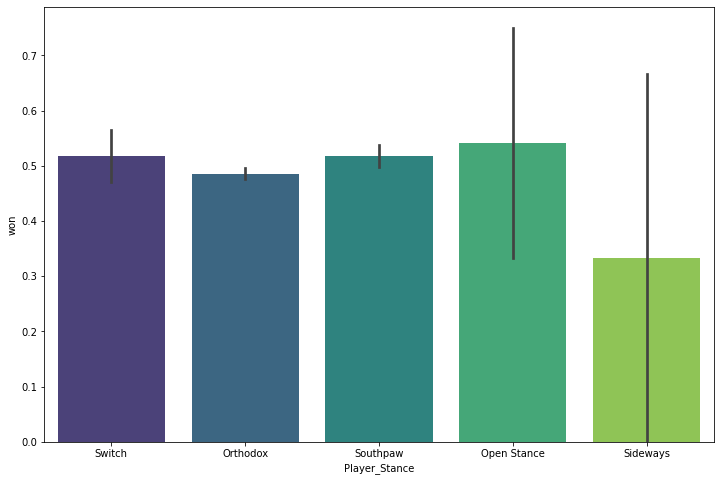

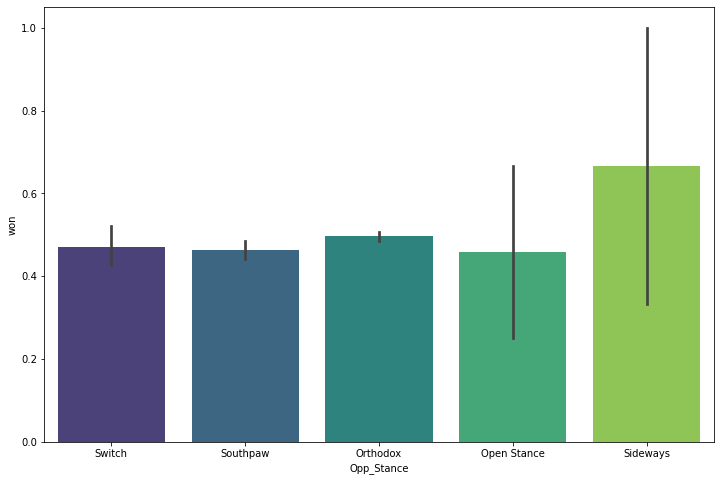

In [159]:
cat_cols = ['Player_Stance', 'Opp_Stance']
def univariate_barplot(df, target, feature):
    plt.figure(figsize = (12,8))
    sns.barplot(y = df[target], x = df[feature], palette = "viridis")#, orient = "h")
    plt.show()
# Categorical variable EDA
for col in cat_cols:
    univariate_barplot(model_df, target = 'won', feature = col)

# Model Building

In [160]:
def get_train_test_holdout(model_df,target, split = 0.3, validation_set = False, categorical_cols = []):
    # randomize data 
    model_df = model_df.sample(frac=1, random_state = 33).reset_index(drop=True)
    X = model_df.copy()
    if len(categorical_cols) > 0:
        X = pd.get_dummies(model_df, drop_first = True, columns = categorical_cols)
    y = model_df[[target]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split, random_state= 33 )
    # for holdout set take piece of train i.e. 0.125 x 0.8 = 0.1 of whole set
    if validation_set == True:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state= 33 ) 
    target_weight = (len(y_train) - y_train[:,0].sum()) / y_train[:,0].sum()
    if validation_set == True:
        return X_train, y_train, X_test, y_test, X_val, y_val, target_weight
    return X_train, y_train, X_test, y_test, target_weight

def reg_imputer(X_train, X_test, X_val = None, drop_cols = []):
    imp_reg = IterativeImputer(random_state=0,min_value = -1000000, max_value = 1000000)
    x_cols = [col for col in X_train if col not in drop_cols]
    X_train_reg = pd.DataFrame(imp_reg.fit_transform(X_train.drop(columns =  drop_cols)), columns =x_cols)
    X_train_reg.loc[:,drop_cols] =  X_train[drop_cols].reset_index(drop = True).copy()
    X_test_reg = pd.DataFrame(imp_reg.transform(X_test.drop(columns =  drop_cols)), columns =x_cols)
    X_test_reg.loc[:,drop_cols] =  X_test[drop_cols].reset_index(drop = True).copy()
    if (X_val is not None):
        X_val_reg = pd.DataFrame(imp_reg.transform(X_val.drop(columns =  drop_cols)), columns =x_cols)
        X_val_reg.loc[:,drop_cols] =  X_val[drop_cols].reset_index(drop = True).copy()
    return X_train_reg, X_test_reg, X_val_reg
    
def model_summary(model, X_train, y_train, X_test, y_test, threshold = 0.5):
    # train set predictions
    train_pred_prob = model.predict_proba(X_train)[:,1]
    train_pred = (train_pred_prob > threshold).astype("int")
    # test set predictions
    test_pred_prob = model.predict_proba(X_test)[:,1]
    test_pred = (test_pred_prob > threshold).astype("int")
    # model report
    print("Confusion Matrix for Test Set")
    print(confusion_matrix(y_test, test_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred))
    disp.plot()
    
    print("\n Classification Report for Test Set")
    print(classification_report(y_test, test_pred))
    
    print("Accuracy Train: {:.4f}".format(accuracy_score(y_train, train_pred)))
    print("AUC Train: {}".format(roc_auc_score(y_train, train_pred)))
    print("Accuracy Test: {:.4f}".format(accuracy_score(y_test, test_pred)))
    print("AUC Test: {}".format(roc_auc_score(y_test, test_pred)))
    
def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC = {:.3f}".format(test_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.title("ROC Plot")
    plt.legend(loc = "lower right")
    plt.show()

In [161]:
model_df = df[cont_cols + cat_cols + ['Player_fighter']]
drop_cols = ['won','Player_fighter']
target = 'won'
X_train, y_train, X_test, y_test, X_val, y_val, target_weight = get_train_test_holdout(model_df,target,0.2,True,cat_cols)
# impute nulls
X_train_reg, X_test_reg, X_val_reg = reg_imputer(X_train, X_test, X_val, drop_cols)

# Logistic Regression

Logistic Regression Result
Confusion Matrix for Test Set
[[1167   62]
 [1083   93]]

 Classification Report for Test Set
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      1229
           1       0.60      0.08      0.14      1176

    accuracy                           0.52      2405
   macro avg       0.56      0.51      0.41      2405
weighted avg       0.56      0.52      0.41      2405

Accuracy Train: 0.5246
AUC Train: 0.5135042664042317
Accuracy Test: 0.5239
AUC Test: 0.514317057172747


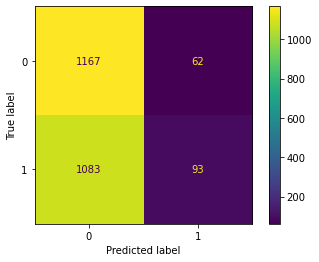

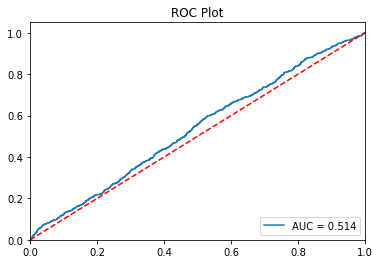

In [162]:
clf = LogisticRegression(random_state=0).fit(X_train_reg.drop(columns =drop_cols), y_train)
log_pred_prob = clf.predict_proba(X_test_reg.drop(columns = drop_cols))[:,1]
log_pred = clf.predict(X_test_reg.drop(columns = drop_cols))

print("Logistic Regression Result")
model_summary(clf, X_train_reg.drop(columns = drop_cols), y_train,
              X_test_reg.drop(columns = drop_cols), y_test)
plot_roc_curve(clf, X_test_reg.drop(columns = drop_cols), y_test)

## XGBoost

[16:18:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Simple XGBoost Result
Confusion Matrix for Test Set
[[774 455]
 [464 712]]

 Classification Report for Test Set
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1229
           1       0.61      0.61      0.61      1176

    accuracy                           0.62      2405
   macro avg       0.62      0.62      0.62      2405
weighted avg       0.62      0.62      0.62      2405

Accuracy Train: 0.9792
AUC Train: 0.9792986364290088
Accuracy Test: 0.6179
AUC Test: 0.6176112430326077


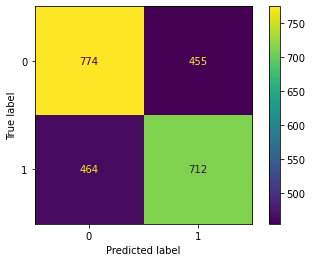

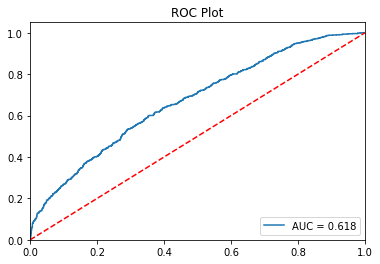

In [163]:
# baseline XGB 
seed = 30
simple_xgb = xgb.XGBClassifier(random_state = seed, scale_pos_weight = target_weight)
simple_xgb.fit(X_train.drop(columns = drop_cols), y_train)
simple_xgb_pred_prob = simple_xgb.predict_proba(X_test.drop(columns = drop_cols))[:,1]
simple_xgb_pred = simple_xgb.predict(X_test.drop(columns = drop_cols))

print("Simple XGBoost Result")
model_summary(simple_xgb, X_train.drop(columns = drop_cols), y_train,
              X_test.drop(columns = drop_cols), y_test)
plot_roc_curve(simple_xgb, X_test.drop(columns = drop_cols), y_test)

# Validation Set results 

Confusion Matrix for Test Set
[[358 220]
 [233 392]]

 Classification Report for Test Set
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       578
           1       0.64      0.63      0.63       625

    accuracy                           0.62      1203
   macro avg       0.62      0.62      0.62      1203
weighted avg       0.62      0.62      0.62      1203

Accuracy Train: 0.9792
AUC Train: 0.9792986364290088
Accuracy Test: 0.6234
AUC Test: 0.6232885813148789


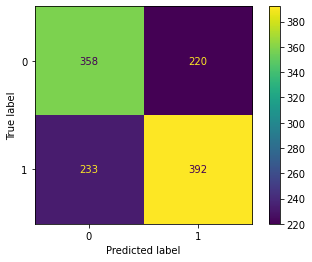

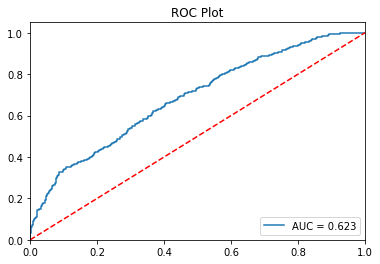

In [164]:
# holdout set results
val_pred = simple_xgb.predict(X_val.drop(columns = drop_cols))
val_pred_proba = simple_xgb.predict_proba(X_val.drop(columns = drop_cols))[:,1]

model_summary(simple_xgb, X_train.drop(columns = drop_cols), y_train,
              X_val.drop(columns = drop_cols), y_val)
plot_roc_curve(simple_xgb, X_val.drop(columns = drop_cols), y_val)

In [165]:
# shap results for model
mybooster = simple_xgb.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfunc(self = None):
    return model_bytearray
mybooster.save_raw = myfunc

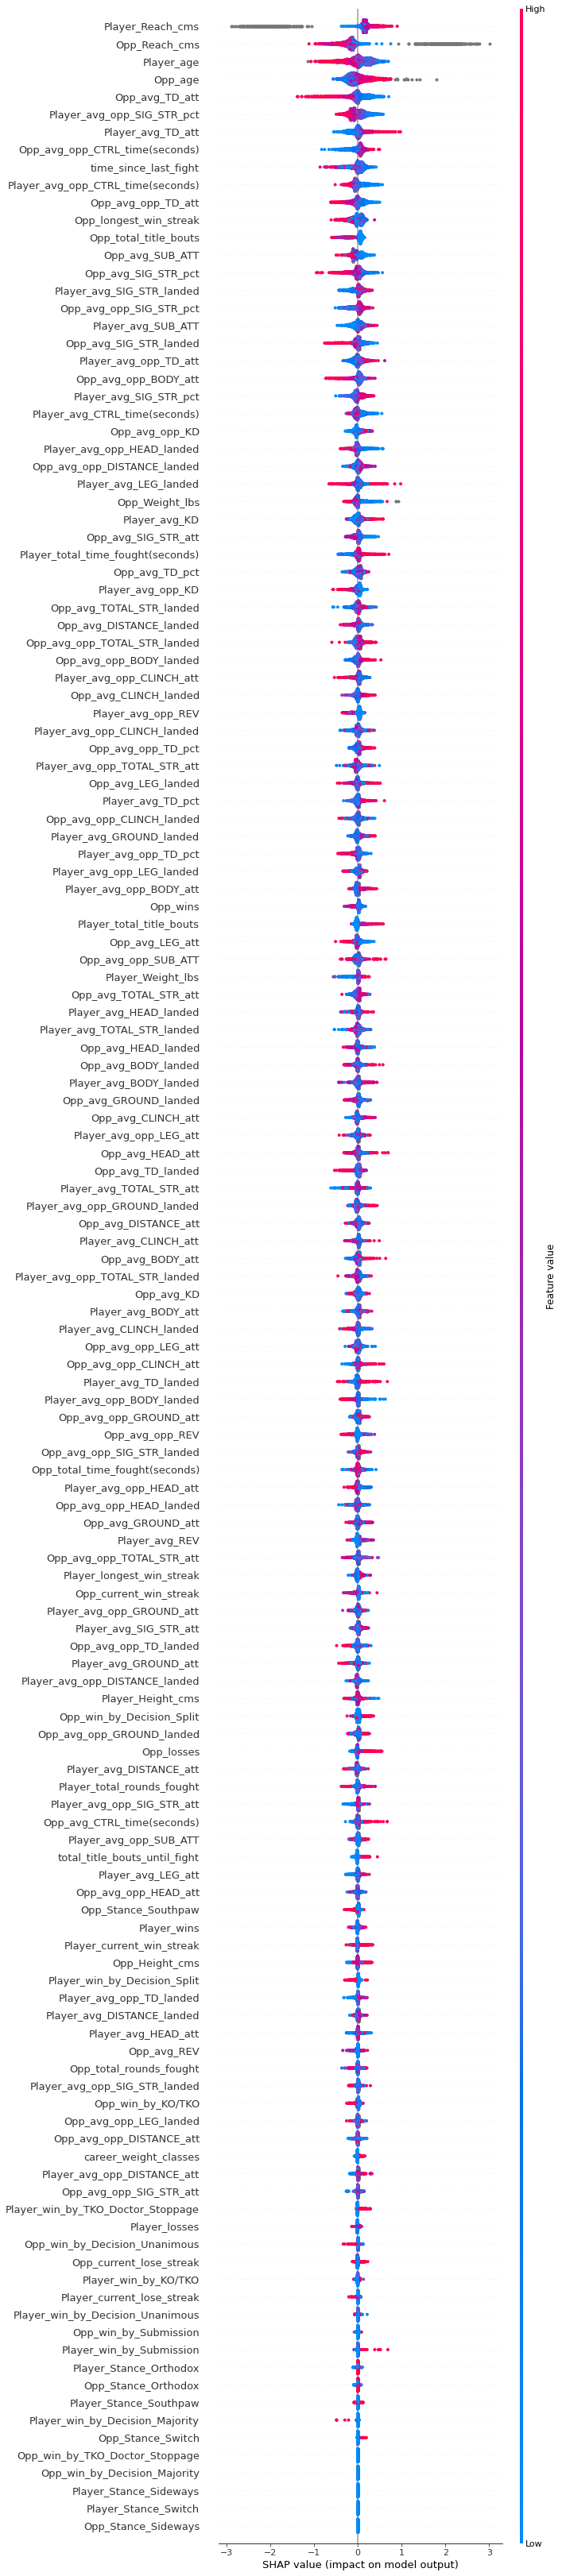

In [166]:
explainer = shap.TreeExplainer(mybooster)
simple_shap_values = explainer.shap_values(X_test.drop(columns = drop_cols))
shap.summary_plot(simple_shap_values, X_test.drop(columns = drop_cols), 
                  max_display = X_test.drop(columns = drop_cols).columns.nunique())